In [49]:
import numpy as np
import keras
import pickle
import zarr
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Activation
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import *


class RL_Datapoint():
    def __init__(self, state, policy, values):
        self.state = state
        self.policy = policy
        self.values = values
        
def __read_file_data(ID, path='dataset/'):
    dataset = zarr.group(store=zarr.ZipStore(path + str(ID) +'.zip', mode="r"))
    X = np.array(dataset['states'])
    policies = np.array(dataset['policies'])
    values = np.array(dataset['values'])
    return X,policies,values

def generator(batch_size, datasetFileLength, path='dataset/'):
    while True:
        files_sequence = list(range(datasetFileLength))
        np.random.shuffle(files_sequence)

        for file_step, file_id in enumerate(files_sequence): 
            X, policies, values = __read_file_data(file_id,path)
#             X = np.rollaxis(X, 1,4).shape
            rand_indices = np.arange(len(X))
            np.random.shuffle(rand_indices)

            for i in range(int(len(X)/batch_size)):
                batch_indices = rand_indices[i*batch_size: (i+1)*batch_size]
                yield X[batch_indices],[policies[batch_indices],values[batch_indices]]
def plotHistory( history):
    import matplotlib.pyplot as plt

    val_loss = history.history['val_loss']
    val_policy_loss = history.history['val_policy_loss']
    val_value_loss = history.history['val_value_loss']
    loss = history.history['loss']
    policy_loss = history.history['policy_loss']
    value_loss = history.history['value_loss']
    
    epochs = range(1,len(loss) + 1)

    # fig, ax = plt.subplots(nrows=2, ncols=2)
    fig = plt.figure()

    plt.subplot(2, 2, 1)
    plt.plot(epochs,loss,'bo',label='loss')
    plt.plot(epochs,val_loss,'b',label='val_loss')
    plt.title = 'Training and validation loss'
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs,policy_loss,'bo',label='policy_loss')
    plt.plot(epochs,val_policy_loss,'b',label='val_policy_loss')
    plt.title = 'Training and validation policy loss'
    plt.legend()        

    plt.subplot(2, 2, 3)
    plt.plot(epochs,value_loss,'bo',label='value_loss')
    plt.plot(epochs,val_value_loss,'b',label='val_value_loss')
    plt.title = 'Training and validation value loss'
    plt.legend()
    plt.show()

In [56]:
def getResidualNetwork(input_shape, output_value=1, output_policy=2272):
    
    channel_pos = 'channels_first'
    inp_shape = Input(input_shape,name='input1')
    x = Conv2D(256, kernel_size=(3,3), padding = 'same', input_shape=input_shape,data_format=channel_pos,name='conv2d_Prep')(inp_shape)
    x = BatchNormalization(axis=1,name='batch_normalization_prep')(x)
    x_a1 = Activation('relu',name='activation_prep')(x)
    activated_x = x_a1
    
#     activated_x, x
    def createResidualBlock(block_nr, activated_x):
        nr = block_nr *2 -1
        x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_'+str(nr), padding='same',data_format=channel_pos)(activated_x)
        x = BatchNormalization(axis=1, name = 'batch_normalization_'+str(nr))(x)
        x = Activation('relu',name = 'activation_'+str(nr))(x)
        x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_'+str(nr+1),padding = 'same',data_format=channel_pos)(x)
        x = BatchNormalization(axis=1, name = 'batch_normalization_'+str(nr+1))(x)
        x = keras.layers.add([x,activated_x],name='add_' + str(block_nr))
        activated_x = Activation('relu',name='activation_'+str(nr+1))(x)
        return activated_x
    
    # build eight residual blocks
    for i in range (1,8):
        activated_x = createResidualBlock(i, activated_x)
        

    
    # Value header
    x = Conv2D(1, kernel_size=(1,1),name='value_conv2d', padding = 'same',data_format=channel_pos)(activated_x)
    xb = BatchNormalization(axis=1,name='value_batch_normalization')(x)
    xA = Activation('relu',name='value_activation')(xb)
    xF = Flatten(name='value_flatten')(xA)
    dense_1 = Dense(256, activation='relu',name='value_dense')(xF)
    value = Dense(output_value, activation='tanh', name='value')(dense_1)

    # Policy Header
    xConv = Conv2D(8, kernel_size=(7,7), padding = 'same',name='policy_conv2d',data_format=channel_pos)(activated_x)
    xb = BatchNormalization(axis=1,name='policy_batch_normalization')(xConv)
    xA = Activation('relu',name='policy_activation')(xb)
    xF = Flatten(name='policy_flatten')(xA)
    policy = Dense(output_policy, activation='softmax', name='policy')(xF)


    from keras.models import Model
    model = Model(inp_shape, [policy,value])

    model.summary()
    return model


<h3>NN Architecture: ResNet</h3>

<h3>Main Parameters of the NN</h3>

In [87]:
# ----------- parameters ----------------
files_len = 1000                                # amount of zip files
file_ids = np.arange(files_len)               
# np.random.shuffle(file_ids)
train_ids = file_ids[:int(len(file_ids)*0.9)] # file_ids for training set
val_ids = file_ids[int(len(file_ids)*0.9):]   # file_ids for validation set 
filepath="models/model-{epoch:02d}.hdf5"      # path to save model
zip_length = 10000                            # amount of datapoints in a zip file
data_len = files_len * zip_length             # whole amount of datapoints in all zip files
batch_size = 256                              # batch size
steps_per_epoch = int((len(train_ids)*zip_length)/batch_size) # amount of batches in one epoch
CLASSES_LEN = 2272                            # amount of classes for policy
channel_pos = 'channels_last'          
dataset_path = 'dataReal/train/'                     # relative directory to the dataset
inp_shape = (60,8,8)                          # shape of a datapoint
val_id = files_len -1 
x_val, policies_val, values_val = __read_file_data(val_id,path=dataset_path)
print('train_ids:',np.min(train_ids),' - ', np.max(train_ids))
print('val_ids:',np.min(val_ids),' - ', np.max(val_ids))
print('x_val:', x_val.shape)

train_ids: 0  -  899
val_ids: 900  -  999
x_val: (10000, 60, 8, 8)


<h3>Build the model</h3>

In [88]:
model = getResidualNetwork(inp_shape, output_policy=CLASSES_LEN)
sgd = optimizers.SGD(lr=0.000, momentum=0.9, decay=0.0, nesterov=False)

def acc_reg(y_true,y_pred):
    return K.constant(1) - K.square(K.mean((y_pred-y_true), axis=1))

model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=sgd,
              metrics=['accuracy'], loss_weights=[0.999,0.001])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 60, 8, 8)     0                                            
__________________________________________________________________________________________________
conv2d_Prep (Conv2D)            (None, 256, 8, 8)    138496      input1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_prep (Batch (None, 256, 8, 8)    1024        conv2d_Prep[0][0]                
__________________________________________________________________________________________________
activation_prep (Activation)    (None, 256, 8, 8)    0           batch_normalization_prep[0][0]   
__________________________________________________________________________________________________
conv2d_1 (

<h3>Define callbacks</h3>

<h4>Callback for checkpoint and tensorboard</h4>

In [89]:
# callbacks 
from datetime import datetime
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
logdir="logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

<h4>Callback for Learning rate</h4>

In [90]:
# learning rate
from  LearningRateScheduler import *
epochs = 5
batch_len = epochs * int(data_len/ (batch_size))
max_lr = 0.001*8
total_it = batch_len
min_lr = 0.0001
print('BatchLen: ', batch_len, ' - DataLen: ', data_len)
lr_schedule = OneCycleSchedule(start_lr=max_lr/8, max_lr=max_lr, cycle_length=total_it*.4, cooldown_length=total_it*.6, finish_lr=min_lr)
scheduler = LinearWarmUp(lr_schedule, start_lr=min_lr, length=total_it/30)
bt = BatchLearningRateScheduler(scheduler)

BatchLen:  195310  - DataLen:  10000000


In [91]:
callbacks_list = [checkpoint,tensorboard_callback,bt]
# callbacks_list = [checkpoint,bt]


In [85]:
from keras import backend
backend.set_image_dim_ordering('th')
print(backend.image_data_format())

channels_first


In [ ]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids),path=dataset_path), steps_per_epoch=int((len(train_ids)*zip_length)/batch_size), callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [policies_val,values_val]))


Epoch 1/5
    2/35156 [..............................] - ETA: 28:41:45 - loss: 7.7773 - policy_loss: 7.7850 - value_loss: 0.0794 - policy_acc: 0.0000e+00 - value_acc: 0.8984

C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.612980). Check your callbacks.
  % delta_t_median)
C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.314450). Check your callbacks.
  % delta_t_median)


35156/35156 [==============================] - 6597s 188ms/step - loss: 3.0065 - policy_loss: 3.0095 - value_loss: 0.0329 - policy_acc: 0.4106 - value_acc: 0.9914 - val_loss: 2.3496 - val_policy_loss: 2.3519 - val_value_loss: 0.0166 - val_policy_acc: 0.4507 - val_value_acc: 0.9998

Epoch 00001: val_loss improved from inf to 2.34960, saving model to models/model-01.hdf5
Epoch:  1  - lr: 0.006133369  - batch: 0  - epoch:  1
Epoch 2/5
11731/35156 [=========>....................] - ETA: 1:15:16 - loss: 1.8444 - policy_loss: 1.8462 - value_loss: 0.0140 - policy_acc: 0.5313 - value_acc: 0.9999

In [33]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids),path=dataset_path), steps_per_epoch=int((len(train_ids)*zip_length)/batch_size), callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [policies_val,values_val]))


Epoch 1/20
  3/351 [..............................] - ETA: 6:45 - loss: 7.9823 - policy_loss: 7.9902 - value_loss: 0.0819 - policy_acc: 0.0000e+00 - policy_acc_reg: 1.0000 - value_acc: 0.9023 - value_acc_reg: 0.9181

C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.362056). Check your callbacks.
  % delta_t_median)


351/351 [==============================] - 71s 204ms/step - loss: 6.3754 - policy_loss: 6.3817 - value_loss: 0.0642 - policy_acc: 0.0608 - policy_acc_reg: 1.0000 - value_acc: 0.9555 - value_acc_reg: 0.9358 - val_loss: 5.7280 - val_policy_loss: 5.7337 - val_value_loss: 0.0760 - val_policy_acc: 0.0772 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9543 - val_value_acc_reg: 0.9240

Epoch 00001: val_loss improved from inf to 5.72800, saving model to models/model-01.hdf5
Epoch:  1  - lr: 0.0014083333  - batch: 0  - epoch:  1
Epoch 2/20
351/351 [==============================] - 69s 195ms/step - loss: 5.5165 - policy_loss: 5.5219 - value_loss: 0.0729 - policy_acc: 0.1007 - policy_acc_reg: 1.0000 - value_acc: 0.9459 - value_acc_reg: 0.9271 - val_loss: 5.8568 - val_policy_loss: 5.8627 - val_value_loss: 0.0466 - val_policy_acc: 0.0708 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9953 - val_value_acc_reg: 0.9534

Epoch 00002: val_loss did not improve from 5.72800
Epoch:  2  - lr: 0.002983333

In [26]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids),path=dataset_path), steps_per_epoch=int((len(train_ids)*zip_length)/batch_size), callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [policies_val,values_val]))


Epoch 1/20
  3/351 [..............................] - ETA: 6:02 - loss: 7.9959 - policy_loss: 8.0039 - value_loss: 0.0590 - policy_acc: 0.0013 - policy_acc_reg: 1.0000 - value_acc: 0.9557 - value_acc_reg: 0.9410   

C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273766). Check your callbacks.
  % delta_t_median)


351/351 [==============================] - 71s 202ms/step - loss: 6.3648 - policy_loss: 6.3711 - value_loss: 0.0418 - policy_acc: 0.0640 - policy_acc_reg: 1.0000 - value_acc: 0.9800 - value_acc_reg: 0.9582 - val_loss: 5.7299 - val_policy_loss: 5.7355 - val_value_loss: 0.0834 - val_policy_acc: 0.0719 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9045 - val_value_acc_reg: 0.9166: 4s - loss: 6.4047 - policy_loss: 6.4111 - value_loss: 0.0422 - policy_acc: 0.0627 - policy_acc_reg: 1.

Epoch 00001: val_loss improved from inf to 5.72986, saving model to models/model-01.hdf5
Epoch:  1  - lr: 0.0014083333  - batch: 0  - epoch:  1
Epoch 2/20
351/351 [==============================] - 68s 195ms/step - loss: 5.4874 - policy_loss: 5.4929 - value_loss: 0.0426 - policy_acc: 0.1075 - policy_acc_reg: 1.0000 - value_acc: 0.9803 - value_acc_reg: 0.9574 - val_loss: 5.8118 - val_policy_loss: 5.8176 - val_value_loss: 0.0696 - val_policy_acc: 0.0746 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9587 - va

351/351 [==============================] - 68s 193ms/step - loss: 2.4175 - policy_loss: 2.4199 - value_loss: 0.0504 - policy_acc: 0.5039 - policy_acc_reg: 1.0000 - value_acc: 0.9717 - value_acc_reg: 0.9496 - val_loss: 3.2652 - val_policy_loss: 3.2684 - val_value_loss: 0.0492 - val_policy_acc: 0.3718 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9718 - val_value_acc_reg: 0.9508

Epoch 00012: val_loss did not improve from 3.26344
Epoch:  12  - lr: 0.00084  - batch: 11  - epoch:  12
Epoch 13/20
351/351 [==============================] - 68s 193ms/step - loss: 2.3114 - policy_loss: 2.3137 - value_loss: 0.0498 - policy_acc: 0.5231 - policy_acc_reg: 1.0000 - value_acc: 0.9723 - value_acc_reg: 0.9502 - val_loss: 3.2726 - val_policy_loss: 3.2759 - val_value_loss: 0.0485 - val_policy_acc: 0.3723 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9759 - val_value_acc_reg: 0.9515

Epoch 00013: val_loss did not improve from 3.26344
Epoch:  13  - lr: 0.0007725  - batch: 12  - epoch:  13
Epoch 14/20


In [19]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids),path=dataset_path), steps_per_epoch=int((len(train_ids)*zip_length)/batch_size), callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [policies_val,values_val]))


Epoch 1/20
  3/351 [..............................] - ETA: 5:37 - loss: 7.8784 - policy_loss: 7.8863 - value_loss: 0.0273 - policy_acc: 0.0000e+00 - policy_acc_reg: 1.0000 - value_acc: 1.0000 - value_acc_reg: 0.9727

C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189484). Check your callbacks.
  % delta_t_median)


351/351 [==============================] - 70s 199ms/step - loss: 6.5544 - policy_loss: 6.5609 - value_loss: 0.0306 - policy_acc: 0.0601 - policy_acc_reg: 1.0000 - value_acc: 0.9980 - value_acc_reg: 0.9694 - val_loss: 6.0043 - val_policy_loss: 6.0103 - val_value_loss: 0.0417 - val_policy_acc: 0.0816 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9831 - val_value_acc_reg: 0.9583

Epoch 00001: val_loss improved from inf to 6.00434, saving model to models/model-01.hdf5
Epoch:  1  - lr: 0.0014083333  - batch: 0  - epoch:  1
Epoch 2/20
351/351 [==============================] - 68s 193ms/step - loss: 5.6100 - policy_loss: 5.6155 - value_loss: 0.0323 - policy_acc: 0.1052 - policy_acc_reg: 1.0000 - value_acc: 0.9960 - value_acc_reg: 0.9677 - val_loss: 5.6622 - val_policy_loss: 5.6678 - val_value_loss: 0.0477 - val_policy_acc: 0.0789 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9824 - val_value_acc_reg: 0.9523 policy_acc: 0.0766 - policy_acc_reg: 1.0000 - va - ETA: 51s - loss: 5.8195 - pol

351/351 [==============================] - 68s 194ms/step - loss: 2.5409 - policy_loss: 2.5434 - value_loss: 0.0438 - policy_acc: 0.4907 - policy_acc_reg: 1.0000 - value_acc: 0.9818 - value_acc_reg: 0.9562 - val_loss: 3.3085 - val_policy_loss: 3.3118 - val_value_loss: 0.0438 - val_policy_acc: 0.3679 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9819 - val_value_acc_reg: 0.9562

Epoch 00012: val_loss improved from 3.33810 to 3.30849, saving model to models/model-12.hdf5
Epoch:  12  - lr: 0.00084  - batch: 11  - epoch:  12
Epoch 13/20
351/351 [==============================] - 68s 193ms/step - loss: 2.4171 - policy_loss: 2.4194 - value_loss: 0.0439 - policy_acc: 0.5130 - policy_acc_reg: 1.0000 - value_acc: 0.9816 - value_acc_reg: 0.9561 - val_loss: 3.3186 - val_policy_loss: 3.3218 - val_value_loss: 0.0415 - val_policy_acc: 0.3744 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9853 - val_value_acc_reg: 0.9585

Epoch 00013: val_loss did not improve from 3.30849
Epoch:  13  - lr: 0.00077

In [31]:
# model.save('models\\BughouseNet220620190437.h5')
history = model.fit_generator(generator(batch_size,len(train_ids),path=dataset_path), steps_per_epoch=int((len(train_ids)*zip_length)/batch_size), callbacks=callbacks_list,
                    epochs=epochs, validation_data=(x_val, [policies_val,values_val]))


Epoch 1/20
  2/351 [..............................] - ETA: 28:15 - loss: 7.8068 - policy_loss: 7.8145 - value_loss: 0.1379 - policy_acc: 0.0000e+00 - policy_acc_reg: 1.0000 - value_acc: 0.7930 - value_acc_reg: 0.8621

C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.915983). Check your callbacks.
  % delta_t_median)


351/351 [==============================] - 81s 230ms/step - loss: 6.7491 - policy_loss: 6.7558 - value_loss: 0.0816 - policy_acc: 0.0573 - policy_acc_reg: 1.0000 - value_acc: 0.9255 - value_acc_reg: 0.9184 - val_loss: 6.0614 - val_policy_loss: 6.0674 - val_value_loss: 0.0348 - val_policy_acc: 0.0812 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.9908 - val_value_acc_reg: 0.9652

Epoch 00001: val_loss improved from inf to 6.06137, saving model to models/model-01.hdf5
Epoch:  1  - lr: 0.0014083333  - batch: 0  - epoch:  1
Epoch 2/20
351/351 [==============================] - 68s 193ms/step - loss: 5.7232 - policy_loss: 5.7289 - value_loss: 0.0434 - policy_acc: 0.1068 - policy_acc_reg: 1.0000 - value_acc: 0.9835 - value_acc_reg: 0.9566 - val_loss: 5.6548 - val_policy_loss: 5.6603 - val_value_loss: 0.1437 - val_policy_acc: 0.0998 - val_policy_acc_reg: 1.0000 - val_value_acc: 0.8379 - val_value_acc_reg: 0.8563: 0.0419 - policy_acc: 0.0952 - policy - ETA: 23s - loss: 5.8369 - policy_loss: 5

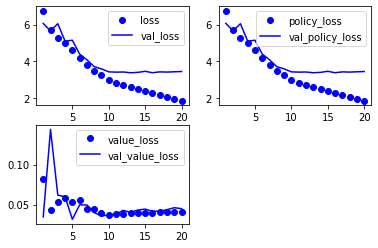

In [36]:
plotHistory(history)


<h3>MNist overfitting</h3>

In [23]:
def getResidualNetwork(input_shape):
    
    channel_pos = 'channels_first'
    inp_shape = Input(input_shape,name='input1')
    x = Conv2D(256, kernel_size=(3,3), padding = 'same', input_shape=input_shape,data_format=channel_pos,name='conv2d_1')(inp_shape)
    x = BatchNormalization(axis=1,name='batch_normalization_1')(x)
    x_a1 = Activation('relu',name='activation_1')(x)

    x = Conv2D(256, kernel_size=(3,3),name ='conv2d_2' ,padding = 'same',data_format=channel_pos)(x_a1)
    x = BatchNormalization(axis=1, name = 'batch_normalization_2')(x)
    x = Activation('relu',name = 'activation_2')(x)
    x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_3',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1, name = 'batch_normalization_3')(x)

    x = keras.layers.add([x,x_a1],name='add1')
    x_a2 = Activation('relu',name='activation_3')(x)
    x = Conv2D(256, kernel_size=(3,3),name = 'conv2d_4', padding = 'same',data_format=channel_pos)(x_a2)
    x = BatchNormalization(axis=1,name = 'batch_normalization_4')(x)
    x = Activation('relu',name='activation_4')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_5',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_5')(x)

    x = keras.layers.add([x,x_a2],name='add_2')
    x_a3 = Activation('relu',name='activation_5')(x)
    x = Conv2D(256, kernel_size=(3,3),name='conv2d_6', padding = 'same',data_format=channel_pos)(x_a3)
    x = BatchNormalization(axis=1,name='batch_normalization_6')(x)
    x = Activation('relu',name='activation_6')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_7',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_7')(x)

    x = keras.layers.add([x,x_a3],name='add_3')
    x_a4 = Activation('relu',name='activation_7')(x)
    x = Conv2D(256, kernel_size=(3,3), name = 'conv2d_8',padding = 'same',data_format=channel_pos)(x_a4)
    x = BatchNormalization(axis=1,name='batch_normalization_8')(x)
    x = Activation('relu',name='activation_8')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_9',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_9')(x)

    x = keras.layers.add([x,x_a4],name='add4')
    x_a5 = Activation('relu',name='activation_9')(x)
    x = Conv2D(256, kernel_size=(3,3),name='conv2d_10', padding = 'same',data_format=channel_pos)(x_a5)
    x = BatchNormalization(axis=1,name='batch_normalization_10')(x)
    x = Activation('relu',name='activation_10')(x)
    x = Conv2D(256, kernel_size=(3,3),name='conv2d_11', padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_11')(x)

    x = keras.layers.add([x,x_a5],name='add_5')
    x_a6 = Activation('relu',name='activation_11')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_12',padding = 'same',data_format=channel_pos)(x_a6)
    x = BatchNormalization(axis=1,name='batch_normalization_12')(x)
    x = Activation('relu',name='activation_12')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_13',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_13')(x)

    x = keras.layers.add([x,x_a6],name='add6')
    x_a7 = Activation('relu',name='activation_13')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_14',padding = 'same',data_format=channel_pos)(x_a7)
    x = BatchNormalization(axis=1,name='batch_normalization_14')(x)
    x = Activation('relu',name='activation_14')(x)
    x = Conv2D(256, kernel_size=(3,3), name='conv2d_15',padding = 'same',data_format=channel_pos)(x)
    x = BatchNormalization(axis=1,name='batch_normalization_15')(x)

    x = keras.layers.add([x,x_a7],name='add_7')
    x_a8 = Activation('relu',name='activation_15')(x)
    x = Conv2D(1, kernel_size=(1,1),name='conv2d_17', padding = 'same',data_format=channel_pos)(x_a8)
    xb = BatchNormalization(axis=1,name='batch_normalization_17')(x)
    xConv = Conv2D(8, kernel_size=(7,7), padding = 'same',name='conv2d_16',data_format=channel_pos)(x_a8)
    xA = Activation('relu',name='activation_17')(xb)
    xb = BatchNormalization(axis=1,name='batch_normalization_16')(xConv)
    xF = Flatten(name='flatten_2')(xA)
    xA = Activation('relu',name='activation_16')(xb)

    dense_1 = Dense(256, activation='relu',name='dense_1')(xF)
    xF = Flatten(name='flatten_1')(xA)

    value = Dense(1, activation='tanh', name='value')(dense_1)
    policy = Dense(10, activation='softmax', name='policy')(xF)

    from keras.models import Model
    model = Model(inp_shape, [policy])

    model.summary()
    return model

In [17]:
from keras.datasets import mnist
img_rows, img_cols = 28, 28
num_classes = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [19]:
from  LearningRateScheduler import *
data_len = len(x_train)
epochs = 20
batch_len = epochs * int(data_len/ (batch_size))
max_lr = 0.001*8
total_it = batch_len
min_lr = 0.0001
print('BatchLen: ', batch_len, ' - DataLen: ', data_len)
lr_schedule = OneCycleSchedule(start_lr=max_lr/8, max_lr=max_lr, cycle_length=total_it*.4, cooldown_length=total_it*.6, finish_lr=min_lr)
scheduler = LinearWarmUp(lr_schedule, start_lr=min_lr, length=total_it/30)
bt = BatchLearningRateScheduler(scheduler)

BatchLen:  4680  - DataLen:  60000


In [20]:
model = getResidualNetwork(input_shape)
sgd = optimizers.SGD(lr=0.000, momentum=0.9, decay=0.0, nesterov=False)

def acc_reg(y_true,y_pred):
    return K.constant(1) - K.square(K.mean((y_pred-y_true), axis=1))
callbacks_list = [bt]

model.compile(loss=['categorical_crossentropy'], optimizer=sgd,
              metrics=['accuracy'])
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test),
#          callbacks=callbacks_list)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 28, 1)   64768       input1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 28, 1)   1024        conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 28, 1)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
  512/60000 [..............................] - ETA: 9:31 - loss: 2.5902 - acc: 0.0762 

C:\Users\MoBray\.conda\envs\TensorFlow_GPU_Keras\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.290199). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 59s 982us/step - loss: 1.3563 - acc: 0.6172 - val_loss: 0.8343 - val_acc: 0.8215
Epoch:  1  - lr: 0.001590812  - batch: 0  - epoch:  1
Epoch 2/20
60000/60000 [==============================] - 54s 901us/step - loss: 0.6064 - acc: 0.8796 - val_loss: 0.4587 - val_acc: 0.9088
Epoch:  2  - lr: 0.0033482907  - batch: 1  - epoch:  2
Epoch 3/20
60000/60000 [==============================] - 54s 903us/step - loss: 0.3410 - acc: 0.9342 - val_loss: 0.3061 - val_acc: 0.9347
Epoch:  3  - lr: 0.0051057693  - batch: 2  - epoch:  3
Epoch 4/20
60000/60000 [==============================] - 54s 902us/step - loss: 0.2215 - acc: 0.9587 - val_loss: 0.2464 - val_acc: 0.9463
Epoch:  4  - lr: 0.006863248  - batch: 3  - epoch:  4
Epoch 5/20
60000/60000 [==============================] - 54s 905us/step - loss: 0.1537 - acc: 0.9743 - val_loss: 0.1996 - val_acc: 0.9525
Epoch:  5  - lr: 0.0073792734  - batch: 4  - epoch:  5
Epoch 6/20
60000/60000 [===================